# Porto Taxi Preprocessing

Import dependencies required.

In [1]:
import os
from pathlib import Path #OS independent path objects
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from tqdm import tqdm

Load data, expects data to be in DATASETS folder of current working directory with /Porto taxi/train.csv/train.csv subfolders.

In [2]:
rel_path = Path('DATASETS/Porto taxi/train.csv/train.csv')
working_dir = Path('/content/drive/MyDrive/COMP9900')

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# cd to working dir applicable only for google colab env
%cd '/content/drive/MyDrive/COMP9900'

/content/drive/MyDrive/COMP9900


In [5]:
#create absolute path to dataset
abs_path = os.getcwd() / rel_path

In [6]:
#check absolute path to dataset
abs_path

PosixPath('/content/drive/MyDrive/COMP9900/DATASETS/Porto taxi/train.csv/train.csv')

The Porto Taxi Dataset contains the trajectory records from 444 taxis in the city of Porto,
Portugal, over the time-span of a year (from 01/07/2013 to 30/06/2014). There are 1,710,670
records in total, where each record contains the trajectory of a particular taxi trip. The tra-
jectory is represented as a list of GPS coordinates that are claimed to have been captured at
an interval of approximately 15 seconds. The dataset comes from the ECML/PKDD 15: Taxi
Trajectory Prediction challenge [8] hosted on Kaggle, which originally ran in 2015. For this project we have only used columns 'TAXI_ID', 'TIMESTAMP', 'MISSING_DATA' and 'POLYLINE'.


In [7]:
columns_to_load = [4,5,7,8]
data = pd.concat([chunk for chunk in tqdm(pd.read_csv(abs_path, usecols = columns_to_load,chunksize=10000), desc='LOADING DATA')])
data.columns = ['TAXI_ID','TIMESTAMP','MISSING_DATA','POLYLINE']

LOADING DATA: 172it [00:47,  3.63it/s]


Here, we can see that the whole dataset contains about 1.72 million trip records.

In [8]:
data.drop(data[data["MISSING_DATA"]==True].index, axis=0, inplace=True) #Drop rows that has missing data

In [9]:
#Now, lets drop MISSING_DATA column as it is not required.
data = data.drop('MISSING_DATA',axis = 1)

In [10]:
#drop trips that has no GPS co-ordinates recorded.
data.drop(data[data.POLYLINE == '[]'].index,axis = 0,inplace = True)
#Since a taxi cannot be at two locations at same time or do two trips at the same time, lets drop such duplicates.
data.drop_duplicates(subset=['TAXI_ID','TIMESTAMP'],inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1704685 entries, 0 to 1710669
Data columns (total 3 columns):
 #   Column     Dtype 
---  ------     ----- 
 0   TAXI_ID    int64 
 1   TIMESTAMP  int64 
 2   POLYLINE   object
dtypes: int64(2), object(1)
memory usage: 52.0+ MB


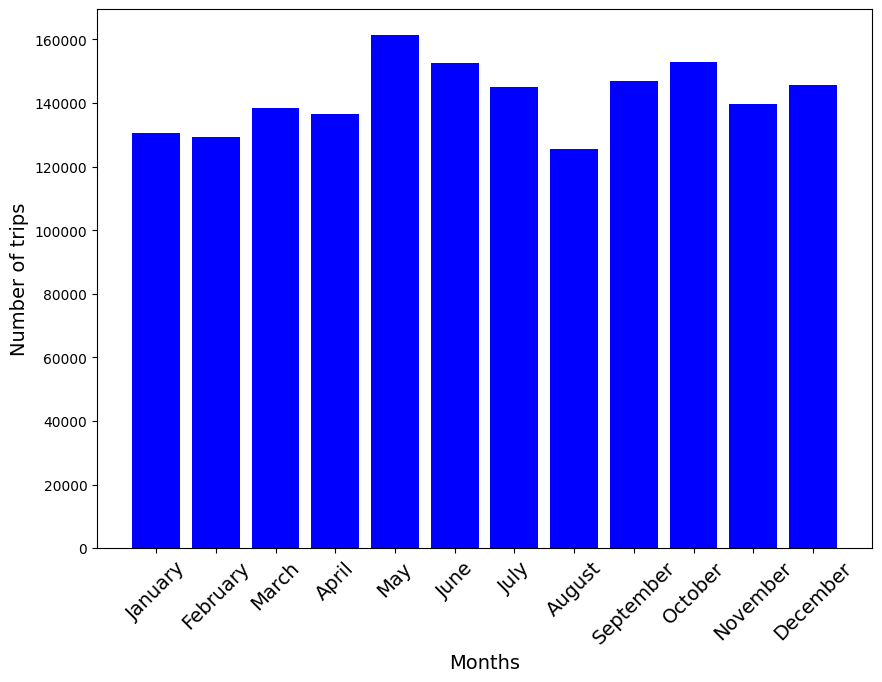

In [11]:
#create new copy of the dataset and find most active month over the year
copied_data = data.copy()

#tag each trip with respective month of the year
copied_data['MONTH'] = copied_data.TIMESTAMP.apply(lambda x: dt.datetime.fromtimestamp(x).month)

#Map integer value of the month to name of the months.
keys_month = np.arange(1,13)
values_month = ['January','February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
month_names = dict(zip(keys_month,values_month))

#Plot number of trips taken each month
plt.figure(figsize=(10,7))
my_colors = 'b'
ax = plt.bar(copied_data.MONTH.value_counts().keys()
        , copied_data.MONTH.value_counts().values
        , color = my_colors)
plt.xticks(copied_data.MONTH.value_counts().keys()
           , copied_data.MONTH.map(month_names).value_counts().keys()
           , rotation = 45
           , size = 14)
plt.xlabel('Months', size = 14)
plt.ylabel('Number of trips', size = 14)
plt.show()

From above bar plot, we can see that **May** has highest number of trips of more than 160000. Therefore, we will keep the trips that are made during May and will discard rest.

In [12]:
val = dict(copied_data.MONTH.value_counts().items()) #create dictionary from series object
month = max(val,key=val.get) #get month that has highest number of trips
#Take data for the month that has highest number of trips, May for this dataset
months_data = copied_data[copied_data['MONTH']==month]

In [13]:
months_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 161482 entries, 1395045 to 1710652
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   TAXI_ID    161482 non-null  int64 
 1   TIMESTAMP  161482 non-null  int64 
 2   POLYLINE   161482 non-null  object
 3   MONTH      161482 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 6.2+ MB


In [14]:
#Get the trip statistics.
freq = (months_data['TAXI_ID']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'TAXI_ID'}, axis=1)
              .sort_values('counts', ascending=True))
print('Number of trips, Min: ',freq['counts'].min(),', Max: ',freq['counts'].max(),',Mean: ', freq['counts'].mean(),'\nModes:\n',freq['counts'].mode())

Number of trips, Min:  11 , Max:  844 ,Mean:  372.0783410138249 
Modes:
 0    303
1    316
2    330
3    497
4    504
5    555
Name: counts, dtype: int64


In [15]:
#drop taxi that has less than mean number of trips. This helps to limit the interpolation for time slots that has missing location records.
taxi_id = freq[freq['counts']<=freq['counts'].mode().iloc[0]]['TAXI_ID'] #get TAXI_ID of taxis which do less than mean number of trips.
for taxi in taxi_id:
  months_data.drop(months_data.loc[months_data['TAXI_ID']== taxi].index,inplace = True)
n_of_taxis = months_data.TAXI_ID.unique().size
print('Number of taxis left :',n_of_taxis,'\n')

<ipython-input-15-eddd11253288>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  months_data.drop(months_data.loc[months_data['TAXI_ID']== taxi].index,inplace = True)


Number of taxis left : 277 



In [16]:
#Let's convert Unix timestamp to standard date and time
months_data.loc[:,'TIMESTAMP'] = pd.to_datetime(months_data['TIMESTAMP'],unit='s',errors = 'coerce')
#check the range of timestamp in the subset of dataset
months_data.TIMESTAMP.min(), months_data.TIMESTAMP.max()

(Timestamp('2014-05-01 00:00:27'), Timestamp('2014-05-31 23:59:50'))

In [17]:
#lets add start location and end location of each trip on months_data for visualisation on a map
months_data.loc[:,'PICK_UP_LOCATION'] = months_data.loc[:,'POLYLINE'].apply(lambda x: eval(x.split()[0])[0]) #applies eval() to convert string to int,takes about a min to complete.
months_data.loc[:,'PICK_UP_LON'] = months_data.loc[:,'PICK_UP_LOCATION'].apply(lambda x:x[0]) #get longitude of trip start location
months_data.loc[:,'PICK_UP_LAT'] = months_data.loc[:,'PICK_UP_LOCATION'].apply(lambda x:x[1]) #get latitude of trip start location


<ipython-input-17-37c18be3736f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  months_data.loc[:,'PICK_UP_LOCATION'] = months_data.loc[:,'POLYLINE'].apply(lambda x: eval(x.split()[0])[0]) #applies eval() to convert string to int,takes about a min to complete.
<ipython-input-17-37c18be3736f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  months_data.loc[:,'PICK_UP_LON'] = months_data.loc[:,'PICK_UP_LOCATION'].apply(lambda x:x[0]) #get longitude of trip start location
<ipython-input-17-37c18be3736f>:4: Se

In [18]:
#Uses plotly library to visualise distribution of pickup locations of all the trips.
def plot_data(taxi_location):
  color_scale = [(0, 'orange'), (1,'red')]

  fig = px.scatter_mapbox(taxi_location,
                          lat="PICK_UP_LAT",
                          lon="PICK_UP_LON",
                          hover_name="TAXI_ID",
                          hover_data=["TIMESTAMP"],
                          color_continuous_scale=color_scale,
                          zoom=9,
                          height=600,
                          width=800)

  fig.update_layout(mapbox_style="open-street-map")
  fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
  fig.show()
plot_data(months_data)

Output hidden; open in https://colab.research.google.com to view.

Above map shows the pick up locations of each trip made during the month of May. Hovering over the locations shows TAXI_ID, latitude & longitude of the pick up location and trip start timestamp.

In [19]:
#Lets drop 'PICK_UP_LON', 'PICK_UP_LAT','PICK_UP_LOCATION','MONTH'
months_data.drop(labels = ['PICK_UP_LON', 'PICK_UP_LAT','PICK_UP_LOCATION','MONTH'], axis=1)
months_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 127201 entries, 1395045 to 1568837
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   TAXI_ID           127201 non-null  int64         
 1   TIMESTAMP         127201 non-null  datetime64[ns]
 2   POLYLINE          127201 non-null  object        
 3   MONTH             127201 non-null  int64         
 4   PICK_UP_LOCATION  127201 non-null  object        
 5   PICK_UP_LON       127201 non-null  float64       
 6   PICK_UP_LAT       127201 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(2)
memory usage: 7.8+ MB


In [20]:
#Convert POLYLINE list of lists to list of lat and lon
months_data.loc[:,"POLYLINE"] = months_data["POLYLINE"].str.replace("[", "")
months_data.loc[:,"POLYLINE"] = months_data["POLYLINE"].str.replace("]", "")
months_data.loc[:,"POLYLINE"] = months_data["POLYLINE"].apply(lambda x: x.split(","))
months_data.head()

,TAXI_ID,TIMESTAMP,POLYLINE,MONTH,PICK_UP_LOCATION,PICK_UP_LON,PICK_UP_LAT
1395045,20000268,2014-05-01 00:00:38,"[-8.615565, 41.140737, -8.615574, 41.140737, -...",5,"[-8.615565, 41.140737]",-8.615565,41.140737
1395076,20000167,2014-05-01 00:02:44,"[-8.610039, 41.155425, -8.609967, 41.15529, -8...",5,"[-8.610039, 41.155425]",-8.610039,41.155425
1395079,20000667,2014-05-01 00:03:49,"[-8.615502, 41.147289, -8.615736, 41.147316, -...",5,"[-8.615502, 41.147289]",-8.615502,41.147289
1395095,20000112,2014-05-01 00:08:42,"[-8.612541, 41.146137, -8.612496, 41.146092, -...",5,"[-8.612541, 41.146137]",-8.612541,41.146137
1395105,20000337,2014-05-01 00:10:40,"[-8.645049, 41.177061, -8.644824, 41.176872, -...",5,"[-8.645049, 41.177061]",-8.645049,41.177061


In [21]:
#convert POLYLINE to geometry that contains tuples of lat & lon
temp_all = []
months_data.loc[:,"GEOMETRY"] = ""
months_data.loc[:,"GEOMETRY"] = months_data.loc[:,"GEOMETRY"].astype("object")
for index, row in months_data.iterrows():
    temp = []
    i = 1
    temp_coords = row["POLYLINE"]
    for coord in temp_coords:
        if i % 2 == 0:
            b = float(coord)
            temp.append((a, b))
        else:
            a = float(coord)
        i += 1

    temp_all.append(temp)
    months_data.at[index, 'GEOMETRY'] = temp

months_data.loc[:,'GEOLEN'] = months_data.loc[:,'GEOMETRY'].apply(lambda x : len(x))
months_data.head()

<ipython-input-21-3a4d86bcd497>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-21-3a4d86bcd497>:20: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,TAXI_ID,TIMESTAMP,POLYLINE,MONTH,PICK_UP_LOCATION,PICK_UP_LON,PICK_UP_LAT,GEOMETRY,GEOLEN
1395045,20000268,2014-05-01 00:00:38,"[-8.615565, 41.140737, -8.615574, 41.140737, -...",5,"[-8.615565, 41.140737]",-8.615565,41.140737,"[(-8.615565, 41.140737), (-8.615574, 41.140737...",21
1395076,20000167,2014-05-01 00:02:44,"[-8.610039, 41.155425, -8.609967, 41.15529, -8...",5,"[-8.610039, 41.155425]",-8.610039,41.155425,"[(-8.610039, 41.155425), (-8.609967, 41.15529)...",21
1395079,20000667,2014-05-01 00:03:49,"[-8.615502, 41.147289, -8.615736, 41.147316, -...",5,"[-8.615502, 41.147289]",-8.615502,41.147289,"[(-8.615502, 41.147289), (-8.615736, 41.147316...",27
1395095,20000112,2014-05-01 00:08:42,"[-8.612541, 41.146137, -8.612496, 41.146092, -...",5,"[-8.612541, 41.146137]",-8.612541,41.146137,"[(-8.612541, 41.146137), (-8.612496, 41.146092...",39
1395105,20000337,2014-05-01 00:10:40,"[-8.645049, 41.177061, -8.644824, 41.176872, -...",5,"[-8.645049, 41.177061]",-8.645049,41.177061,"[(-8.645049, 41.177061), (-8.644824, 41.176872...",49


In [22]:
#Create timestamps of 10 min time steps
start,end = months_data.TIMESTAMP.min(), months_data.TIMESTAMP.max()
start,end = start.replace(second = 0,minute = 0,hour =0),end.replace(second = 0) #round seconds to zero
start,end

(Timestamp('2014-05-01 00:00:00'), Timestamp('2014-05-31 23:59:00'))

In [23]:
time_step = pd.date_range(start,end,freq ='10min',normalize =True)
time_step

DatetimeIndex(['2014-05-01 00:00:00', '2014-05-01 00:10:00',
               '2014-05-01 00:20:00', '2014-05-01 00:30:00',
               '2014-05-01 00:40:00', '2014-05-01 00:50:00',
               '2014-05-01 01:00:00', '2014-05-01 01:10:00',
               '2014-05-01 01:20:00', '2014-05-01 01:30:00',
               ...
               '2014-05-30 22:30:00', '2014-05-30 22:40:00',
               '2014-05-30 22:50:00', '2014-05-30 23:00:00',
               '2014-05-30 23:10:00', '2014-05-30 23:20:00',
               '2014-05-30 23:30:00', '2014-05-30 23:40:00',
               '2014-05-30 23:50:00', '2014-05-31 00:00:00'],
              dtype='datetime64[ns]', length=4321, freq='10T')

In [24]:
#create datetime object of 15 seconds
interval = dt.timedelta(seconds = 15)

#create list of timestamp that adds 15 seconds to each trip's start timestamp
months_data.loc[:,"new_timestamp"] = ""
months_data.loc[:,"new_timestamp"] = months_data.loc[:,"new_timestamp"].astype("object")
for index, row in months_data.iterrows():
    mul_seq = [y for y in range(row['GEOLEN'])]
    t_seq = [interval * y for y in mul_seq]
    new_timestamp = [row['TIMESTAMP'] + time for time in t_seq]
    months_data.at[index,'new_timestamp'] = new_timestamp
months_data.head()

<ipython-input-24-babe6b66b568>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,TAXI_ID,TIMESTAMP,POLYLINE,MONTH,PICK_UP_LOCATION,PICK_UP_LON,PICK_UP_LAT,GEOMETRY,GEOLEN,new_timestamp
1395045,20000268,2014-05-01 00:00:38,"[-8.615565, 41.140737, -8.615574, 41.140737, -...",5,"[-8.615565, 41.140737]",-8.615565,41.140737,"[(-8.615565, 41.140737), (-8.615574, 41.140737...",21,"[2014-05-01 00:00:38, 2014-05-01 00:00:53, 201..."
1395076,20000167,2014-05-01 00:02:44,"[-8.610039, 41.155425, -8.609967, 41.15529, -8...",5,"[-8.610039, 41.155425]",-8.610039,41.155425,"[(-8.610039, 41.155425), (-8.609967, 41.15529)...",21,"[2014-05-01 00:02:44, 2014-05-01 00:02:59, 201..."
1395079,20000667,2014-05-01 00:03:49,"[-8.615502, 41.147289, -8.615736, 41.147316, -...",5,"[-8.615502, 41.147289]",-8.615502,41.147289,"[(-8.615502, 41.147289), (-8.615736, 41.147316...",27,"[2014-05-01 00:03:49, 2014-05-01 00:04:04, 201..."
1395095,20000112,2014-05-01 00:08:42,"[-8.612541, 41.146137, -8.612496, 41.146092, -...",5,"[-8.612541, 41.146137]",-8.612541,41.146137,"[(-8.612541, 41.146137), (-8.612496, 41.146092...",39,"[2014-05-01 00:08:42, 2014-05-01 00:08:57, 201..."
1395105,20000337,2014-05-01 00:10:40,"[-8.645049, 41.177061, -8.644824, 41.176872, -...",5,"[-8.645049, 41.177061]",-8.645049,41.177061,"[(-8.645049, 41.177061), (-8.644824, 41.176872...",49,"[2014-05-01 00:10:40, 2014-05-01 00:10:55, 201..."


In [25]:
#Explode 'GEOMETRY' column to series of 15 seconds interval locations for sampling
df_exploded = months_data.explode(['GEOMETRY','new_timestamp']).reset_index(drop = True)

In [26]:
#drop old 'TIMESTAMP' column
df_exploded.drop('TIMESTAMP',axis = 1,inplace = True)

In [27]:
#Convert trajectories to cartesian, taken from https://github.com/erik-buchholz/RAoPT
def convert_coord(latitudes: np.ndarray, longitudes: np.ndarray) -> (np.ndarray, np.ndarray):
    R_e = 6317  #Average radius of earth in KM
    alpha = np.radians(latitudes)
    beta = np.radians(longitudes)
    x = R_e * np.cos(alpha) * np.cos(beta)
    y = R_e * np.cos(alpha) * np.sin(beta)
    return x, y


In [28]:
#Create list of user trajectories. Each trajectory is a dataframe
users = []
for taxi in df_exploded.TAXI_ID.unique():
  user = df_exploded.loc[df_exploded.TAXI_ID == taxi].copy()
  user.sort_values(by = 'new_timestamp')
  user.reset_index(drop = True, inplace = True)
  user.loc[:,'lon'], user.loc[:,'lat'] = zip(*user['GEOMETRY'])
  # Unwrap the angles
  user.loc[:,'lon'] = np.rad2deg(np.unwrap(np.deg2rad(user.loc[:,'lon'])))
  user.loc[:,'lat'] = np.rad2deg(np.unwrap(np.deg2rad(user.loc[:,'lat'])))
  #Sample dataframe
  conversion = {'lon':'first','lat':'first'}
  user_sampled = user.resample('10T',on = 'new_timestamp').agg(conversion)

  #Check if all timesteps are contained in each user, if not add and fill values with nan
  user_sampled = user_sampled.reindex(time_step,fill_value = np.nan)

  #nearest interpolation
  user_sampled.loc[:,'lon'] = user_sampled.loc[:,'lon'].interpolate(method='nearest')
  user_sampled.loc[:,'lat'] = user_sampled.loc[:,'lat'].interpolate(method='nearest')

  #forward and backward fill if no nearest values available in original data frame
  user_sampled.loc[:,'lon'] = user_sampled.loc[:,'lon'].ffill().bfill()
  user_sampled.loc[:,'lat'] = user_sampled.loc[:,'lat'].ffill().bfill()
  #convert to cartesian
  user_sampled.loc[:,'X'],user_sampled.loc[:,'Y'] = convert_coord(user_sampled['lat'].to_numpy(), user_sampled['lon'].to_numpy())
  user_sampled.loc[:,'TAXI_ID'] = taxi
  users.append(user_sampled)


In [29]:
# Calculate percentiles for X
X_1 = round(pd.concat(users)['X'].quantile(0.01))
X_99 = round(pd.concat(users)['X'].quantile(0.995))
X_min,X_max = round(pd.concat(users)['X'].min()),round(pd.concat(users)['X'].max())

#Calculate percentiles for Y
Y_1 = round(pd.concat(users)['Y'].quantile(0.01))
Y_99 = round(pd.concat(users)['Y'].quantile(0.995))
Y_min,Y_max = round(pd.concat(users)['Y'].min()),round(pd.concat(users)['Y'].max())

print('One percentile of X:',X_1,'99th Percentile of X:',X_99)
print('X-Min:',X_min,', X-Max:',X_max)
print('One percentile of Y:',Y_1,'99th Percentile of Y:',Y_99)
print('Y-Min:',Y_min,', Y-Max:',Y_max)
length, width = abs(X_99 - X_1),abs(Y_99 - Y_1)
print('length:',length, 'Width:',width)

One percentile of X: 4696 99th Percentile of X: 4707
X-Min: 4494 , X-Max: 4880
One percentile of Y: -718 99th Percentile of Y: -705
Y-Min: -860 , Y-Max: -256
length: 11 Width: 13


In [30]:
#Make square bounding box and divisible into equal grids

def make_equal_and_even(a, b):
    # Base case: If a and b are equal, return them
    if a == b:
        return a, b

    # Choose one integer to modify
    if a < b:
        a += 1
    else:
        b += 1

    # Make the modified integer even
    if a % 2 != 0:
        a += 1
    if b % 2 != 0:
        b += 1

    # Recursive case: Call the function with modified values
    return make_equal_and_even(a, b)

(a,b) = make_equal_and_even(length,width)
print('Original dimensions:',(a,b))
X_low = X_1 - (a - length )/2
X_high = X_99 + (a - length)/2
Y_low = Y_1 - (b - width)/2
Y_high = Y_99 + (b - width)/2
print(f'The bounding box is: X_low = {X_low}, X_high = {X_high}, Y_low = {Y_low} and Y_high = {Y_high} ')

Original dimensions: (14, 14)
The bounding box is: X_low = 4694.5, X_high = 4708.5, Y_low = -718.5 and Y_high = -704.5 


In [31]:
#pad the values exceeding boundary to boundary values.
ts_data = pd.concat(users)
ts_data.loc[ts_data['Y'] > Y_high,'Y'] = Y_high
ts_data.loc[ts_data['Y'] < Y_low,'Y'] = Y_low
ts_data.loc[ts_data['X'] < X_low,'X'] = X_low
ts_data.loc[ts_data['X'] > X_high,'X'] = X_high

#Sanity check for max and min values
print('Max - X: ',ts_data.X.max(),', Min - X: ',ts_data.X.min(),', Max - Y: ' ,ts_data.Y.max(),', Min - Y: ',ts_data.Y.min())

Max - X:  4708.5 , Min - X:  4694.5 , Max - Y:  -704.5 , Min - Y:  -718.5


In [32]:
cell_dia = 2 #set cell diameter
#create zeroes numpy array of size final_length x final_width
flength , fwidth = abs(X_high - X_low),abs(Y_high - Y_low)
shape = (int(flength/cell_dia),int(fwidth/cell_dia)) #shape of array
dtype = [('x','f4'),('y','f4')] #create datatype of array elements as tuple of floats
cells = np.zeros(shape,dtype = dtype)

#fill cells with their location as centre of each grid
grid_map = {}
x_start,y_start = X_low + cell_dia/2,Y_low +cell_dia/2
for i in range(int(flength/cell_dia)):
  cells[i,:]['x'] = x_start
  for j in range(int(fwidth/cell_dia)):
    cells[i,j]['y'] = y_start
    y_start += cell_dia
    grid_map[tuple(cells[i,j])] = (i,j)
  y_start = Y_low +cell_dia/2
  x_start += cell_dia


In [33]:
#Get base station location
xcenter = cells[:,:]['x']
ycenter = cells[:,:]['y']

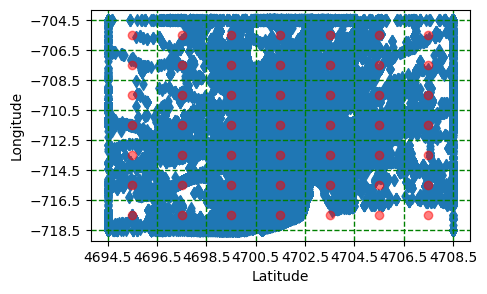

In [34]:
#Plot taxi locations and base station location on grid
fig = plt.figure(figsize = (4.9,3))
ax = fig.gca()
xticks =np.arange(X_low,X_high+cell_dia,cell_dia) #from lowest value of x to highest value of x with steps of cell_dia
yticks = np.arange(Y_low,Y_high+cell_dia,cell_dia) #from lowest value of y to highest value of y with steps of cell_dia
ax.set_xticks(xticks)
ax.set_yticks(yticks)
ax.set_xlabel('Latitude')
ax.set_ylabel('Longitude')
plt.scatter(x= ts_data.X,y=ts_data.Y,marker = 'd')
plt.scatter(x = xcenter,y = ycenter,color = 'r',alpha = .5)
plt.grid(color='g', linestyle='--', linewidth=1)
plt.show()

In [35]:
#Maps x,y value of user to x,y value of base station
def find_cell(value,xticks,cell_dia):
  if value == xticks[-1]: #if the value is highest/last element in the list
    return (xticks[-1] - cell_dia/2)
  else:
    i = next(j for j,e in enumerate(xticks) if e > value) #get the integer location where the value should be inserted.
    return (xticks[i-1] + cell_dia/2)

ts_data.loc[:,"xcell"] = 0.0
ts_data.loc[:,"ycell"] = 0.0
ts_data.loc[:,"xcell"] = ts_data.loc[:,"X"].apply(find_cell,args = (xticks,cell_dia))
ts_data.loc[:,"ycell"] = ts_data.loc[:,"Y"].apply(find_cell,args = (yticks,cell_dia))

In [36]:
#create tuple (xcell,ycell) as tower from columns xcell and ycell
ts_data['tower'] = list(zip(ts_data['xcell'],ts_data['ycell']))
ts_data.drop(['xcell','ycell'],axis = 1,inplace = True)

In [37]:
#get mapping of cell id to tower location
ts_data['cell_id'] = ts_data['tower'].apply(lambda x: grid_map[x])

In [38]:
ts_data.head()

,lon,lat,X,Y,TAXI_ID,tower,cell_id
2014-05-01 00:00:00,-8.615565,41.140737,4703.623474,-712.663238,20000268,"(4703.5, -713.5)","(4, 2)"
2014-05-01 00:10:00,-8.613918,41.142942,4703.485816,-712.504073,20000268,"(4703.5, -713.5)","(4, 2)"
2014-05-01 00:20:00,-8.613918,41.142942,4703.485816,-712.504073,20000268,"(4703.5, -713.5)","(4, 2)"
2014-05-01 00:30:00,-8.613918,41.142942,4703.485816,-712.504073,20000268,"(4703.5, -713.5)","(4, 2)"
2014-05-01 00:40:00,-8.613918,41.142942,4703.485816,-712.504073,20000268,"(4703.5, -713.5)","(4, 2)"


In [39]:
#create grid map
locations = [x for x in cells.flatten()] #create list of base station locations
bottom_left = [(x - cell_dia/2,y - cell_dia/2) for x,y in locations] #create list of bottom left point of each cell
top_right = [(x + cell_dia/2,y + cell_dia/2) for x,y in locations] #create list of top right point of each cell
loc = [(x,y) for x,y in locations] #create list of tuples of x and y.
grid = pd.DataFrame({'ID':grid_map.values(),'towerlocation':loc,'bottomleft':bottom_left,'topright':top_right})

In [40]:
#group by time slots
grouped = ts_data.groupby([ts_data.index])

In [41]:
df_by_index = {} #holds dataframes for each time step, each df contains which user is at which location at that time step
for indexvalue,grouped_df in grouped:
  df_by_index[indexvalue] = grouped_df


In [42]:
col = list(grid_map.values()) #column heading are grid_map's values i.e, cell id
agg_porto = pd.DataFrame(0,columns = col,index = ts_data.index.unique())

In [43]:
for index in df_by_index.keys():
  x = df_by_index[index]
  counts = x['cell_id'].value_counts().reset_index()
  counts.columns = ['cell_id','counts']
  agg_porto.loc[index,counts['cell_id']] = np.array(counts['counts'])

In [44]:
def count_users(group):
  index = group.index
  counts = group['cell_id'].value_counts().reset_index()
  counts.columns = ['cell_id','counts']
  agg_porto.loc[index,counts['cell_id']] = np.array(counts['counts'])

In [45]:
#Sanity check for total number of users at all the locations at particular timestamp
agg_porto.sum(axis =1)

2014-05-01 00:00:00    277
2014-05-01 00:10:00    277
2014-05-01 00:20:00    277
2014-05-01 00:30:00    277
2014-05-01 00:40:00    277
                      ... 
2014-05-30 23:20:00    277
2014-05-30 23:30:00    277
2014-05-30 23:40:00    277
2014-05-30 23:50:00    277
2014-05-31 00:00:00    277
Length: 4321, dtype: int64

In [46]:
agg_porto.head()

,"(0, 0)","(0, 1)","(0, 2)","(0, 3)","(0, 4)","(0, 5)","(0, 6)","(1, 0)","(1, 1)","(1, 2)",...,"(5, 4)","(5, 5)","(5, 6)","(6, 0)","(6, 1)","(6, 2)","(6, 3)","(6, 4)","(6, 5)","(6, 6)"
2014-05-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2014-05-01 00:10:00,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2014-05-01 00:20:00,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2014-05-01 00:30:00,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
2014-05-01 00:40:00,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0


In [47]:
#Create file names for aggregated data and grid describing the dataset
agg_fname = f'./processed/{n_of_taxis} Users Porto Taxi  {shape[0]} x {shape[1]}.csv'
grid_fname = f'./processed/Porto taxi grid {shape[0]} x {shape[1]}.csv'

In [48]:
agg_porto.to_csv(agg_fname,index_label = 'datetime')

In [49]:
grid.to_csv(grid_fname,index_label = 'index')

In [50]:
#group by trajectories/taxi for ground truth
groupedby_users = ts_data.groupby([ts_data.TAXI_ID])

In [51]:
#create ground truth dataframe
ground_truth =groupedby_users[['TAXI_ID','tower','cell_id']]

In [52]:
#Create ground truth file name describing the dataset
gt_fname = f'./processed/{n_of_taxis} Users {shape[0]}x{shape[1]} ground_truth.csv'

In [53]:
#write ground truth csv file, appends to the file

for user, group in ground_truth:
  if os.path.isfile(gt_fname):
    group.to_csv(gt_fname,mode = 'a',header = False)
  else:
    group.to_csv(gt_fname,mode = 'a')